<a href="https://colab.research.google.com/github/jeremysb1/data_analysis_projects/blob/main/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics Project

The business has just been through its first winter sale. Stakeholders are interested in knowing which products performed best during the Christmas period so they can streamline the products they advertise in future sale periods.

I will do this by analyzing up to two months of events data, presented as two separate data sources with identical structures. Events refer not just to sales but to more general customer actions, such as viewing a product on the website or placing it into their virtual cart.

Some aspects they care about when ranking their products:

*  Volume of sales;
*  Total revenue from a single product;
*  Popularity measured by the number of unique customers who bought a product;
*  Conversion, meaning the percentage of time a product is bought once it has been placed in the virtual shopping cart; and
*  Products with increased performance from November to December.

The output of the analysis should be recommendations of the best-performing products on whichever dimension(s) I choose.

The recommendation could be for single product IDs or broader ones relating to brands or product categories, as long as your choice of “best” product is justified by my analysis.
`


A Minimum Viable Answer should contain:

- Measurements of our chosen metrics at a product level (e.g., a table of total revenue in December by product, sorted in descending revenue order)
- A ranking so we can highlight top performers
Justifications for which metrics were chosen
- A summary of our findings in tabular or visual form
- Recommendations for further iterations (if requested)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

november = pd.read_csv('/content/drive/MyDrive/Data Analysis Projects/Metrics/november.csv')
december = pd.read_csv('/content/drive/MyDrive/Data Analysis Projects/Metrics/december.csv')

events = pd.concat([november, december], axis=0, ignore_index=True)
print(events.shape)

(7033125, 9)


In [2]:
events.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code         0
brand            395108
price                 0
user_id               0
user_session         27
dtype: int64

In [3]:
events["event_time"] = pd.to_datetime(events["event_time"], format="%Y-%m-%d %H:%M:%S %Z")
events["event_time"].agg(["min", "max"])

min   2019-11-01 00:00:14+00:00
max   2019-12-31 23:59:09+00:00
Name: event_time, dtype: datetime64[ns, UTC]

In [4]:
(
    events
    .assign(month=events["event_time"].dt.month,
            day=events["event_time"].dt.day)
    .groupby("month")
    ["day"]
    .nunique()
)

month
11    30
12    31
Name: day, dtype: int64

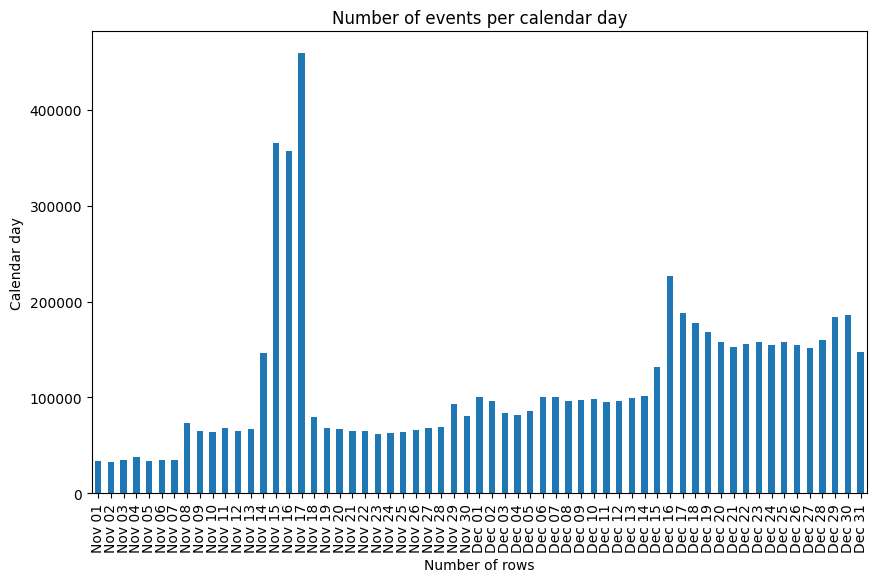

In [5]:
fig, axis = plt.subplots(figsize=(10, 6))

(
    events
    .assign(month=events["event_time"].dt.month, day=events["event_time"].dt.day)
    .groupby(["month", "day"])
    .size()
    .plot
    .bar(ax=axis)
)

labels = (
    pd.date_range(
        events["event_time"].dt.date.min(),
        events["event_time"].dt.date.max(),
        freq = "D")
    .strftime("%b %d")
)

axis.set(title="Number of events per calendar day",
         xlabel="Number of rows",
         ylabel="Calendar day",
         xticklabels=labels)

plt.show()

In [6]:
events["event_type"].value_counts(dropna=False)

event_type
cart        5276372
purchase    1756753
Name: count, dtype: int64

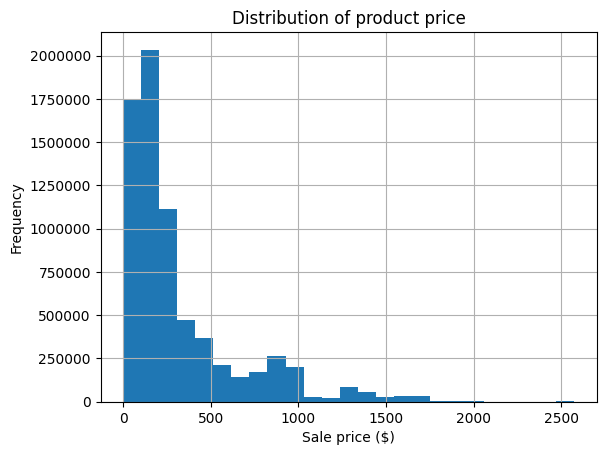

In [7]:
fig, axis = plt.subplots()

(
    events["price"]
    .hist(bins=25, ax=axis)
)

#disable scientific notation
axis.ticklabel_format(useOffset=False, style='plain')

axis.set(title="Distribution of product price",
         xlabel="Sale price ($)",
         ylabel="Frequency")

plt.show()

In [8]:
events["brand"].value_counts().head(10)

brand
samsung    1756284
apple      1368364
xiaomi      722125
huawei      263155
oppo        128661
lg          123581
sony         78615
artel        72124
lucente      69998
lenovo       59700
Name: count, dtype: int64

## Are products correctly categorized?

One way to check this is to ask: do we have any product IDs that are assigned to multiple categories?

In [9]:
(
    events
    .groupby("product_id")
    ["category_code"]
    .nunique()
    .loc[lambda x: x > 1]
    .sort_values(ascending=False)
)

product_id
1000978      2
13900087     2
13900049     2
13900054     2
13900055     2
            ..
5701183      2
5701186      2
5701190      2
5701192      2
100028003    2
Name: category_code, Length: 12884, dtype: int64

In [10]:
events["category_code"].value_counts().head(10)

category_code
construction.tools.light            1823398
electronics.smartphone              1577185
electronics.audio.headphone          240308
electronics.clocks                   233198
sport.bicycle                        231644
apparel.shoes                        212586
appliances.kitchen.refrigerators     190523
appliances.personal.massager         185601
appliances.environment.vacuum        170290
appliances.kitchen.washer            170121
Name: count, dtype: int64

In [11]:
(
    events
    .loc[events["category_code"] == "construction.tools.light", "brand"]
    .value_counts()
    .head(10)
)

brand
samsung    727599
apple      521481
xiaomi     304546
huawei     149347
oppo        68446
vivo        10709
meizu        9093
honor        4389
nokia        3231
omron        3003
Name: count, dtype: int64

In [12]:
dupe_product_ids = (
    events
    .groupby("product_id")
    ["category_code"]
    .nunique()
    .loc[lambda x: x > 1]
    .index
    .values
)

dupe_product_ids[:10]

array([1000978, 1001588, 1001618, 1001619, 1002098, 1002100, 1002101,
       1002225, 1002367, 1002482])

In [13]:
(
    events.loc[events["product_id"] == 1001588, "category_code"].value_counts()
)

category_code
construction.tools.light    50
electronics.smartphone      22
Name: count, dtype: int64

In [14]:
def get_correct_category_code(product_id_rows):
    # product_id_rows is all rows for a given product ID
    # so we can find the two categories associated with this ID
    categories = product_id_rows["category_code"].value_counts()

    if "construction.tools.light" in categories.index:
        return categories.index.drop("construction.tools.light").values[0]

    else:
        return categories.index[0]

corrected_categories = (
    events[events["product_id"].isin(dupe_product_ids)]
    .groupby("product_id")
    .apply(get_correct_category_code)
    .reset_index(name="corrected_category")
)

corrected_categories.head()

,product_id,corrected_category
0,1000978,electronics.smartphone
1,1001588,electronics.smartphone
2,1001618,electronics.smartphone
3,1001619,electronics.smartphone
4,1002098,electronics.smartphone


In [15]:
events = events.merge(corrected_categories, on="product_id", how="left")
events.loc[events["corrected_category"].notnull(), "category_code"] = \
    events.loc[events["corrected_category"].notnull(), "corrected_category"]

events["category_code"].value_counts()

category_code
electronics.smartphone              3350680
sport.bicycle                        384120
appliances.personal.massager         254300
electronics.clocks                   228546
appliances.kitchen.refrigerators     214637
                                     ...   
apparel.skirt                           261
construction.tools.soldering            200
sport.diving                            144
computers.components.sound_card         118
auto.accessories.light                   41
Name: count, Length: 134, dtype: int64

In [16]:
events["category"] = events["category_code"].str.split(".").str[0]

events = events.rename(columns={"category_code": "subcategory"})

events["category"].value_counts()

category
electronics     3908916
appliances      1250149
apparel          540955
sport            439029
computers        291790
furniture        216264
construction     144637
kids              98236
auto              89079
accessories       39350
country_yard       6106
medicine           5616
stationery         2998
Name: count, dtype: int64

In [17]:
duplicated_brands = (
    events
    .assign(brand = events["brand"].fillna("No brand"))
    .groupby("product_id")
    ["brand"]
    .nunique()
    .loc[lambda x: x > 1]
    .index
)

print(len(duplicated_brands))

duplicated_brands[:10]

1245


Index([1001618, 1002310, 1002786, 1002877, 1003080, 1003224, 1003238, 1003330,
       1003604, 1003851],
      dtype='int64', name='product_id')

In [19]:
def get_correct_brand(product_id_rows):
    # product_id_rows is all rows for a given product ID
    # so we can find the brands associated with this ID
    # value_counts will give us only non-NA values
    brand_counts = product_id_rows["brand"].value_counts(dropna=False)

    if isinstance(brand_counts.index[0], str):
        # no NULLs, just return the majority brand
        return brand_counts.index[0]

    # now if np.NaN is the only value, return it
    if len(brand_counts) == 1:
        return np.nan

    # otherwise return the second value (the majority non-null value)
    return brand_counts.index[1]

corrected_brands = (
    events[events["product_id"].isin(duplicated_brands)]
    .groupby("product_id")
    .apply(get_correct_brand)
    .reset_index(name="corrected_brand")
)

corrected_brands.head()

,product_id,corrected_brand
0,1001618,apple
1,1002310,lg
2,1002786,apple
3,1002877,samsung
4,1003080,huawei
